In [1]:
# ------------------------------------------------------------------------------
# Modeling: Load data and helper functions
# ------------------------------------------------------------------------------

# Core
import sys
from pathlib import Path
import json

import numpy as np
import pandas as pd
from scipy import sparse
import joblib

# Modeling (what you actually use)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.inspection import PartialDependenceDisplay

# Viz
import matplotlib.pyplot as plt

# Make sure we can import from src/
PROJECT_ROOT = Path.cwd().parent  # repo root (one level up from notebooks/)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.utils import evaluate_model
print("✅ utils imported successfully")

# ------------------------------------------------------------------------------
# Load preprocessed data from ../data/features
# ------------------------------------------------------------------------------

FEAT = Path("../data/features")

# Sparse matrices (reduced to top 500 features)
X_train = sparse.load_npz(FEAT / "dtm_train_opt.npz")
X_test  = sparse.load_npz(FEAT / "dtm_test_opt.npz")

# Labels
y_train = joblib.load(FEAT / "y_train_balanced.joblib")
y_test  = joblib.load(FEAT / "y_test.joblib")

# Metadata
vectorizer = joblib.load(FEAT / "vectorizer.joblib")
with open(FEAT / "top_features_500.json") as f:
    top_features = json.load(f)

print("✅ Data successfully loaded.")
print(f"Train DTM shape: {X_train.shape}")
print(f"Test  DTM shape: {X_test.shape}")
print(f"Number of top features: {len(top_features)}")

✅ utils imported successfully
✅ Data successfully loaded.
Train DTM shape: (20666, 500)
Test  DTM shape: (140000, 500)
Number of top features: 500


## Logistic Regression

In [2]:
# ------------------------------------------------------------------------------
# Logistic Regression: alpha ∈ [0,1], lambda via C=1/lambda
# ------------------------------------------------------------------------------
# Use the reduced sparse matrices loaded earlier:
# X_train, X_test, y_train, y_test, top_features

# Optional: scale to speed convergence (no centering on sparse)
scaler = StandardScaler(with_mean=False)
X_tr = scaler.fit_transform(X_train)
X_te = scaler.transform(X_test)

# Grids
alpha_grid  = np.round(np.linspace(0, 1, 11), 1)      # 0.0, 0.1, ..., 1.0
lambda_grid = np.logspace(-4, 0, 30, base=10.0)       # 30 values from 1e-4 to 1
C_grid      = 1.0 / lambda_grid

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
lr_results = []

for alpha in alpha_grid:
    # Set penalty/solver to mimic glmnet: alpha=0 -> L2, 1 -> L1, else elastic net
    kwargs = dict(Cs=C_grid, cv=cv, scoring="accuracy", n_jobs=-1, refit=True, solver="saga", max_iter=2000)
    if alpha == 0.0:
        cv_model = LogisticRegressionCV(penalty="l2", **kwargs)
    elif alpha == 1.0:
        cv_model = LogisticRegressionCV(penalty="l1", **kwargs)
    else:
        cv_model = LogisticRegressionCV(penalty="elasticnet", l1_ratios=[alpha], **kwargs)

    cv_model.fit(X_tr, y_train)
    best_C = float(cv_model.C_[0])
    best_lambda = 1.0 / best_C

    # Evaluate on TEST (threshold 0.5)
    test_probs = cv_model.predict_proba(X_te)[:, 1]
    y_pred = (test_probs > 0.5).astype(int)
    metrics = evaluate_model(y_test, y_pred)

    lr_results.append({
        "Alpha": alpha,
        "Lambda": best_lambda,
        "Accuracy": metrics["Accuracy"],
        "Balanced_Accuracy": metrics["Balanced_Accuracy"]
    })

lr_results = pd.DataFrame(lr_results).sort_values("Accuracy", ascending=False).reset_index(drop=True)
print("Top rows of CV results:")
display(lr_results.head(5))

# ---- Refit final model on best alpha/lambda ----
best_alpha  = float(lr_results.loc[0, "Alpha"])
best_lambda = float(lr_results.loc[0, "Lambda"])
best_C      = 1.0 / best_lambda

if best_alpha == 0.0:
    final_lr = LogisticRegression(penalty="l2", C=best_C, solver="saga", max_iter=4000, n_jobs=-1)
elif best_alpha == 1.0:
    final_lr = LogisticRegression(penalty="l1", C=best_C, solver="saga", max_iter=4000, n_jobs=-1)
else:
    final_lr = LogisticRegression(penalty="elasticnet", l1_ratio=best_alpha, C=best_C, solver="saga", max_iter=4000, n_jobs=-1)

final_lr.fit(X_tr, y_train)

# ---- Test evaluation ----
test_probs = final_lr.predict_proba(X_te)[:, 1]
y_pred = (test_probs > 0.5).astype(int)
final_metrics = evaluate_model(y_test, y_pred)
print("\nFinal model metrics:")
print(final_metrics)

# Optional: confusion matrix table
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print("\nConfusion Matrix (rows=true, cols=pred):")
display(pd.DataFrame(cm, index=["True 0","True 1"], columns=["Pred 0","Pred 1"]))

# ---- Coefficients (sorted by absolute value) ----
feat_names = top_features[:X_tr.shape[1]]  # should align with reduced DTM columns
coefs = final_lr.coef_.ravel()
coefficients_df = (
    pd.DataFrame({"Feature": feat_names, "Coefficient": coefs})
      .reindex(range(len(coefs)))
      .assign(Abs=lambda d: d["Coefficient"].abs())
      .sort_values("Abs", ascending=False)
      .drop(columns="Abs")
)
print("\nTop 10 features by |coefficient|:")
display(coefficients_df.head(10))

Top rows of CV results:


,Alpha,Lambda,Accuracy,Balanced_Accuracy
0,0.7,1.000000,0.798264,0.791913
1,1.0,0.727895,0.798236,0.791929
2,0.2,0.022122,0.797850,0.791860
3,0.1,0.022122,0.797843,0.791856
4,0.0,0.022122,0.797836,0.791851



Final model metrics:
{'Accuracy': 0.7900285714285714, 'Precision': 0.948414591153232, 'Recall': 0.7892706751346127, 'Specificity': 0.793671201061712, 'F1_Score': 0.8615551264541045, 'Balanced_Accuracy': 0.7914709380981624}

Confusion Matrix (rows=true, cols=pred):


,Pred 0,Pred 1
True 0,19137,4975
True 1,24421,91467



Top 10 features by |coefficient|:


,Feature,Coefficient
0,great,0.463696
1,excellent,0.409350
8,rude,-0.370588
5,lovely,0.329852
15,fantastic,0.313102
7,dirty,-0.311343
2,poor,-0.305275
11,perfect,0.305215
10,amazing,0.297056
21,loved,0.287201


## Naive bayes

In [3]:
# ------------------------------------------------------------------------------
# Naive Bayes (Multinomial): tune Laplace (alpha), evaluate, and refit best
# ------------------------------------------------------------------------------

# Grid of Laplace values (alpha in MultinomialNB)
laplace_values = np.round(np.arange(0.0, 2.0 + 1e-9, 0.1), 1)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
cv_rows = []

for alpha in laplace_values:
    fold_acc = []
    fold_f1  = []

    for tr_idx, va_idx in cv.split(X_train, y_train):
        X_tr, X_va = X_train[tr_idx], X_train[va_idx]
        y_tr, y_va = y_train[tr_idx], y_train[va_idx]

        nb = MultinomialNB(alpha=float(alpha))
        nb.fit(X_tr, y_tr)

        # Robustly get the column index for class "1"
        idx_pos = int(np.where(nb.classes_ == 1)[0][0])
        va_probs = nb.predict_proba(X_va)[:, idx_pos]
        y_hat    = (va_probs > 0.5).astype(int)

        m = evaluate_model(y_va, y_hat)
        fold_acc.append(m["Accuracy"])
        fold_f1.append(m["F1_Score"])

    cv_rows.append({
        "Laplace": float(alpha),
        "Accuracy": float(np.mean(fold_acc)),
        "F1_Score": float(np.mean(fold_f1)),
    })

cv_results = pd.DataFrame(cv_rows).sort_values("Accuracy", ascending=False).reset_index(drop=True)
print("Top CV results:")
display(cv_results.head(5))

# ---- Refit final model on full train with best Laplace ----
best_alpha = float(cv_results.loc[0, "Laplace"])
final_nb = MultinomialNB(alpha=best_alpha).fit(X_train, y_train)

# Test set evaluation
idx_pos = int(np.where(final_nb.classes_ == 1)[0][0])
test_probs = final_nb.predict_proba(X_test)[:, idx_pos]
y_pred     = (test_probs > 0.5).astype(int)

final_metrics = evaluate_model(y_test, y_pred)
print("\nFinal model metrics (Naive Bayes):")
print(final_metrics)

# Confusion matrix (pretty table)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print("\nConfusion Matrix (rows=true, cols=pred):")
display(pd.DataFrame(cm, index=["True 0","True 1"], columns=["Pred 0","Pred 1"]))

/Users/lucasvercauteren/Desktop/gehaalde vakken/Master eur/seminar/final paper/hotel-reviews-sentiment/.conda/lib/python3.11/site-packages/sklearn/naive_bayes.py:898: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/lucasvercauteren/Desktop/gehaalde vakken/Master eur/seminar/final paper/hotel-reviews-sentiment/.conda/lib/python3.11/site-packages/sklearn/naive_bayes.py:898: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/lucasvercauteren/Desktop/gehaalde vakken/Master eur/seminar/final paper/hotel-reviews-sentiment/.conda/lib/python3.11/site-packages/sklearn/naive_bayes.py:898: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/lucasvercauteren/Desktop/gehaalde vakken/Master eur/seminar/final paper/hotel-reviews-sentiment/.conda/lib/python3.11/site-packages/sklearn/naive_bayes.py:898: RuntimeWarn

Top CV results:


,Laplace,Accuracy,F1_Score
0,1.6,0.790283,0.790459
1,1.9,0.790187,0.790477
2,1.5,0.790187,0.790339
3,0.1,0.790187,0.789758
4,1.4,0.790138,0.790282



Final model metrics (Naive Bayes):
{'Accuracy': 0.7738857142857143, 'Precision': 0.946437278721194, 'Recall': 0.7704421510423858, 'Specificity': 0.7904362972793629, 'F1_Score': 0.8494191964837841, 'Balanced_Accuracy': 0.7804392241608744}

Confusion Matrix (rows=true, cols=pred):


,Pred 0,Pred 1
True 0,19059,5053
True 1,26603,89285


## Random Forest

In [4]:
# ------------------------------------------------------------------------------
# Random Forest (MDI only): tune mtry & trees via OOB, evaluate, show MDI
# ------------------------------------------------------------------------------

# Convert reduced sparse matrices to dense (sklearn RF expects dense)
X_tr = X_train.toarray()
X_te = X_test.toarray()
y_tr = np.asarray(y_train).astype(int)
y_te = np.asarray(y_test).astype(int)

# --- 1) Tune mtry (max_features) by OOB error ---
p = X_tr.shape[1]
sqrt_p = int(np.floor(np.sqrt(p)))
mtry_grid = [sqrt_p - 10, sqrt_p - 5, sqrt_p, sqrt_p + 5, sqrt_p + 10]
mtry_grid = sorted({max(1, min(p, m)) for m in mtry_grid})  # keep within [1, p]

oob_err_mtry = []
for m in mtry_grid:
    rf = RandomForestClassifier(
        n_estimators=500,
        max_features=m,
        oob_score=True,
        bootstrap=True,
        n_jobs=-1,
        random_state=123
    )
    rf.fit(X_tr, y_tr)
    oob_err_mtry.append(1.0 - rf.oob_score_)

optimal_mtry = mtry_grid[int(np.argmin(oob_err_mtry))]
print(f"Optimal mtry (max_features): {optimal_mtry}")

# --- 2) Tune number of trees (n_estimators) by OOB error ---
tree_grid = list(range(100, 1001, 100))  # 100..1000 step 100
oob_err_trees = []
for ntrees in tree_grid:
    rf = RandomForestClassifier(
        n_estimators=ntrees,
        max_features=optimal_mtry,
        oob_score=True,
        bootstrap=True,
        n_jobs=-1,
        random_state=123
    )
    rf.fit(X_tr, y_tr)
    oob_err_trees.append(1.0 - rf.oob_score_)

optimal_trees = tree_grid[int(np.argmin(oob_err_trees))]
print(f"Optimal number of trees: {optimal_trees}")

# --- 3) Fit final RF with optimal settings ---
final_rf = RandomForestClassifier(
    n_estimators=optimal_trees,
    max_features=optimal_mtry,
    oob_score=True,
    bootstrap=True,
    n_jobs=-1,
    random_state=123
).fit(X_tr, y_tr)

# --- 4) Evaluate on test set (probability for class 1) ---
idx_pos = int(np.where(final_rf.classes_ == 1)[0][0])
test_probs = final_rf.predict_proba(X_te)[:, idx_pos]
y_pred = (test_probs > 0.5).astype(int)

metrics = evaluate_model(y_te, y_pred)
print("\nFinal RF metrics:")
print(metrics)

cm = confusion_matrix(y_te, y_pred, labels=[0, 1])
print("\nConfusion Matrix (rows=true, cols=pred):")
display(pd.DataFrame(cm, index=["True 0","True 1"], columns=["Pred 0","Pred 1"]))


Optimal mtry (max_features): 12
Optimal number of trees: 700

Final RF metrics:
{'Accuracy': 0.7818, 'Precision': 0.9393171896878346, 'Recall': 0.7872601132127571, 'Specificity': 0.755557398805574, 'F1_Score': 0.8565929319863296, 'Balanced_Accuracy': 0.7714087560091656}

Confusion Matrix (rows=true, cols=pred):


,Pred 0,Pred 1
True 0,18218,5894
True 1,24654,91234


## Model interpretation

Top 15 features by MDI (Gini Importance):


,Feature,MDI
0,great,0.027187
1,room,0.026723
2,excellent,0.020236
3,small,0.016027
4,poor,0.015772
5,staff,0.015694
6,hotel,0.015506
7,breakfast,0.015219
8,helpful,0.014965
9,friendly,0.013865


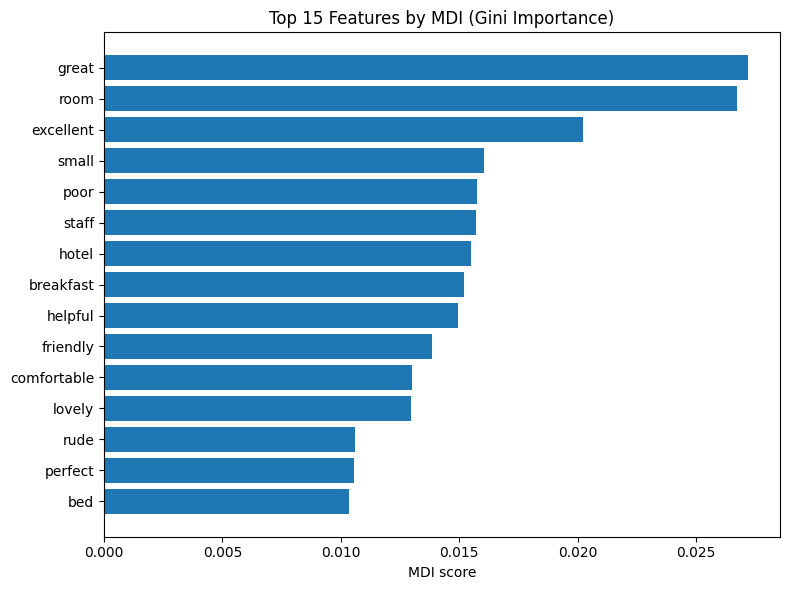

In [5]:
# ------------------------------------------------------------------------------
# Model interpretation (part 1): MDI (Gini) importances
# ------------------------------------------------------------------------------
# Feature names must align with X_tr columns
feat_names = top_features[:X_tr.shape[1]]

# MDI (Gini) importance from the fitted RF
mdi_df = (
    pd.DataFrame({"Feature": feat_names, "MDI": final_rf.feature_importances_})
      .sort_values("MDI", ascending=False)
      .reset_index(drop=True)
)

print("Top 15 features by MDI (Gini Importance):")
display(mdi_df.head(15))

# Save & plot top-15 MDI
FIG_DIR = Path("../reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(8, 6))
top15 = mdi_df.head(15).iloc[::-1]  # reverse so the largest bar is on top
plt.barh(top15["Feature"], top15["MDI"])
plt.xlabel("MDI score")
plt.title("Top 15 Features by MDI (Gini Importance)")
plt.tight_layout()
plt.savefig(FIG_DIR / "top15_mdi_plot.png", dpi=200)
plt.show()

/Users/lucasvercauteren/Desktop/gehaalde vakken/Master eur/seminar/final paper/hotel-reviews-sentiment/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 4 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Users/lucasvercauteren/Desktop/gehaalde vakken/Master eur/seminar/final paper/hotel-reviews-sentiment/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/lucasvercauteren/Desktop/gehaalde vakken/Master eur/seminar/final paper/hotel-reviews-sentiment/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py

PDP plot saved to: /Users/lucasvercauteren/Desktop/gehaalde vakken/Master eur/seminar/final paper/hotel_reviews_sent_python_notebook/reports/figures/pdp_plot.png


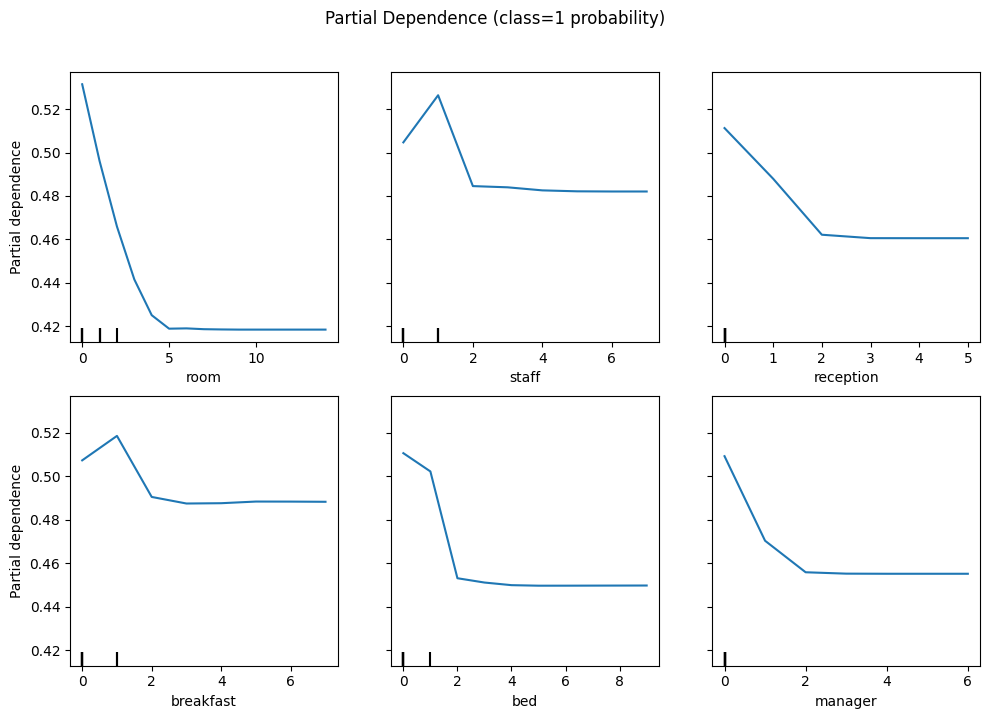

In [9]:
# ------------------------------------------------------------------------------
# Model interpretation: Partial Dependence Plots (PDPs)
# ------------------------------------------------------------------------------

# Build DataFrame for feature-name addressing
feat_names = top_features[:X_tr.shape[1]]
X_train_df = pd.DataFrame(X_tr, columns=feat_names)

# Pick features you care about; fallback to top-3 by MDI if missing
requested = ["room", "staff", "reception", "breakfast", "bed", "manager"]  # edit as needed
available = [f for f in requested if f in X_train_df.columns]
if not available:
    available = mdi_df["Feature"].head(3).tolist()
    print("Requested PDP features not found. Falling back to:", available)

# Create the figure and plot
fig, ax = plt.subplots(figsize=(10, 7))
PartialDependenceDisplay.from_estimator(
    estimator=final_rf,
    X=X_train_df,
    features=available,              # list of feature names
    kind="average",
    target=1,                        # class=1 (positive sentiment)
    response_method="predict_proba",
    grid_resolution=20,
    n_jobs=-1,
    ax=ax,
)

# Title & layout
plt.suptitle("Partial Dependence (class=1 probability)", y=1.02)
plt.tight_layout()

# --- SAVE TO reports/figures ---
FIG_DIR = Path("../reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

output_path = FIG_DIR / "pdp_plot.png"
plt.savefig(output_path, dpi=200)
print(f"PDP plot saved to: {output_path.resolve()}")

# Show the plot in notebook
plt.show()

In [12]:
MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

import joblib

joblib.dump(final_lr, MODELS_DIR / "model_logreg.joblib")
joblib.dump(final_nb, MODELS_DIR / "model_naivebayes.joblib")
joblib.dump(final_rf, MODELS_DIR / "model_randomforest.joblib")
print("✅ All models saved to:", MODELS_DIR.resolve())


✅ All models saved to: /Users/lucasvercauteren/Desktop/gehaalde vakken/Master eur/seminar/final paper/hotel_reviews_sent_python_notebook/models
